In [3]:
import numpy as np
import h5py
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# change some plotting defaults
plt.rc('xtick',labelsize=26)
plt.rc('ytick',labelsize=26)
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.25
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.25
plt.rcParams['axes.linewidth'] = 2

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

# useful throughout
base_dir = '../../lya_mf_emulator/data/'
emudir = '../../lya_linear_flux/data/emu_30mpc_lores/'
zz = np.array([5.4,5.2,5.0,4.8,4.6,4.4,4.2,4.0,3.8,3.6,3.4,3.2,3.0,2.8,2.6,2.4,2.2,2.0])
test = h5py.File(emudir+'cc_emulator_flux_vectors_tau1000000.hdf5', 'r')
kf_test = test['kfkms'][:]
test.close()

### Functions for plotting averaged errors

In [4]:
# currently using std of |prediction/truth - 1| for uncertainty
# to propagate from prediction uncertainty (error):
# error/prediction * |prediction/truth - 1| / N

# for using multiple emulators to get error trend with training size 
def get_mean_std(base_dir, kf, kfmin=False, kfmax=False):
    # get indices for k-range, if selected
    kinds = (kf > 0)
    if kfmin:
        kinds = (kf > kfmin)
    if kfmax:
        kinds = (kf <= kfmax)    
        
    # order from low LF to high
    order = np.array([15,17,18,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16])
    files = np.sort(glob.glob(base_dir+'*4_err.txt'))[order]
    absmean, absstd = np.zeros(files.size), np.zeros(files.size)
    for i, file in enumerate(files):
        pred_true = np.loadtxt(file).reshape(10,18,25)[kinds]
        pred_true = pred_true[~np.isnan(pred_true)]
        absmean[i] = np.mean(np.abs(pred_true-1))
        absstd[i] = np.std(np.abs(pred_true-1))
        
    # get the HF trends (10 LF, 20 LF, 30 LF, 40 LF)
    absmeanHF, absstdHF = np.zeros([4, 5]), np.zeros([4, 5])
    for j in range(4):
        files = np.sort(glob.glob(base_dir+'*'+str(j+1)+'0-*_err.txt'))
        for i, file in enumerate(files):
            pred_true = np.loadtxt(file).reshape(10,18,25)[kinds]
            pred_true = pred_true[~np.isnan(pred_true)]
            absmeanHF[j, i] = np.mean(np.abs(pred_true-1))
            absstdHF[j, i] = np.std(np.abs(pred_true-1))
    
    return absmean, absstd, absmeanHF, absstdHF

# get error for a specific emulator (averaged over z or k)
def get_mean_std_one(base_dir, kf, lf, hf, z_or_k='k', kfmin=False, kfmax=False, nargp=False):
    # get indices for k-range, if selected
    kinds = (kf > 0)
    if kfmin:
        kinds = (kf > kfmin)
    if kfmax:
        kinds = (kf <= kfmax)
        
    # get correct file
    if lf is None:
        file = base_dir+'cc_linear-'+str(hf)+'hf_err.txt'
    elif hf is None:
        file = base_dir+'cc_linear-'+str(lf)+'lf_err.txt'
    elif nargp:
        file = base_dir+'cc_linear-'+str(lf)+'-'+str(hf)+'_err_nargp.txt'
    else:
        file = base_dir+'cc_linear-'+str(lf)+'-'+str(hf)+'_err.txt'
        
    pred_true = np.loadtxt(file).reshape(10, 18, 25)
    if z_or_k == 'z':
        pred_true = np.transpose(pred_true, axes=[0, 2, 1])
        kinds = np.transpose(kinds, axes=[0, 2, 1])
    
    absmean, absstd = np.zeros(pred_true.shape[2]), np.zeros(pred_true.shape[2])
    for i in range(pred_true.shape[2]):
        absmean[i] = np.mean(np.abs(pred_true[:,:,i][kinds[:,:,i]]-1))
        absstd[i] = np.std(np.abs(pred_true[:,:,i][kinds[:,:,i]]-1))

    return absmean, absstd

### Plot examples of flux power spectrum

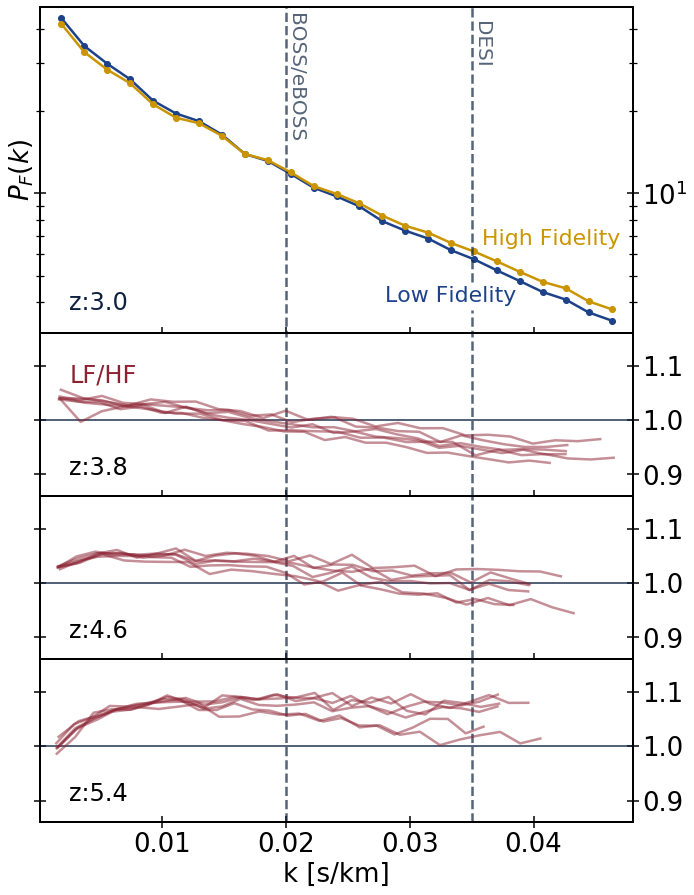

In [3]:
# plot the difference between HF and LF for each simulation pair available

# lores, hires indices: 0:18, 1:4, 2:17, 3:36, 4:26, 5:1
hires = h5py.File('../data/current_emulators/box30/hires/cc_emulator_flux_vectors_tau1000000.hdf5-6', 'r')
hrfp, hrkf = hires['flux_vectors'][:].reshape(6, 18, 25), hires['kfkms'][:]
hires.close()
lores = h5py.File('../data/current_emulators/box30/lores/cc_emulator_flux_vectors_tau1000000.hdf5-40', 'r')
lrfp, lrkf = lores['flux_vectors'][:].reshape(40, 18, 25)[np.array([18,4,17,36,26,1])], lores['kfkms'][:][np.array([18,4,17,36,26,1])]
lores.close()

xr = [0.0001, 0.048]
yr = [0.86, 1.16]
fig, ax = plt.subplots(figsize=(10.625, 3*5), nrows=4, ncols=1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]})
plt.setp(ax, ylim=yr, xlim=xr)

# plot the top panel -- example flux power for LF and HF
z = 12 # z=3
ax[0].plot(lrkf[4, z], lrfp[4, z], 'o-', c=c_skyline, lw=2.5)
ax[0].plot(hrkf[4, z], hrfp[4, z], 'o-', c=c_sunshine, lw=2.5)

ax[0].plot([0.02, 0.02], [0,100], '--', c=c_midnight, lw=2.5, alpha=0.7)
ax[0].plot([0.035, 0.035], [4.75,100], '--', c=c_midnight, lw=2.5, alpha=0.7)
ax[0].plot([0.035, 0.035], [0,3.75], '--', c=c_midnight, lw=2.5, alpha=0.7)

ax[0].text(0.0358, 6.5e0, 'High Fidelity', c=c_sunshine, fontsize=22)
ax[0].text(0.028, 4e0, 'Low Fidelity', c=c_skyline, fontsize=22)
ax[0].text(0.0025, 3.75, 'z:'+str(zz[z]), c=c_midnight, fontsize=24)
ax[0].text(0.02, 16, 'BOSS/eBOSS', c=c_midnight, fontsize=20, alpha=0.7, rotation=-90)
ax[0].text(0.035, 30, 'DESI', c=c_midnight, fontsize=20, alpha=0.7, rotation=-90)

ax[0].set_ylabel(r'$P_{F}(k)$', fontsize=26)
ax[0].set_yscale('log')
ax[0].set_ylim([lrfp[4, z].min()*0.9, lrfp[4, z].max()*1.1])

ax[0].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax[0].tick_params(which='minor', length=8, labelright=False, labelleft=False)

# plot the lower panels -- LF/HF for all pairs
j = 1
for z in np.array([8,4,0]): #z = 3.8, 4.6, 5.4
    ax[j].plot(xr, [1,1], '-', c=c_midnight, lw=2., alpha=0.7)
    ax[j].plot([0.02, 0.02], yr, '--', c=c_midnight, lw=2.5, alpha=0.7)
    ax[j].plot([0.035, 0.035], yr, '--', c=c_midnight, lw=2.5, alpha=0.7)
    for i in range(6):
        ax[j].plot(lrkf[i, z], lrfp[i, z]/hrfp[i, z], '-', c=c_flatirons, lw=2.5, alpha=0.5)
    ax[j].text(0.0025, 0.9, 'z:'+str(zz[z]), fontsize=24)
    
    ax[j].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
    ax[j].tick_params(which='minor', length=8, labelright=False, labelleft=False)
    j += 1

ax[1].text(0.0025, 1.07, 'LF/HF', c=c_flatirons, fontsize=24) 
ax[3].set_xlabel('k [s/km]', fontsize=26)
fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/fluxpower_comp.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Plot examples of spectra and simulation

In [4]:
ff = h5py.File('../../bigdat/current_emulators/hi_res/SPECTRA_011/lya_forest_spectra.hdf5', 'r')
hi_tau = ff['tau']['H']['1']['1215'][3]
ff.close()
ff = h5py.File('../../bigdat/current_emulators/lo_res/SPECTRA_011/lya_forest_spectra.hdf5', 'r')
lo_tau = ff['tau']['H']['1']['1215'][3]
ff.close()

# ycofm, zcofm = 73.94643603, 26520.96547116
# cutoff = 1500 kpc
part_hi = np.loadtxt('../../bigdat/current_emulators/particles.txt').T
part_lo = np.loadtxt('../../bigdat/current_emulators/lo_particles.txt').T

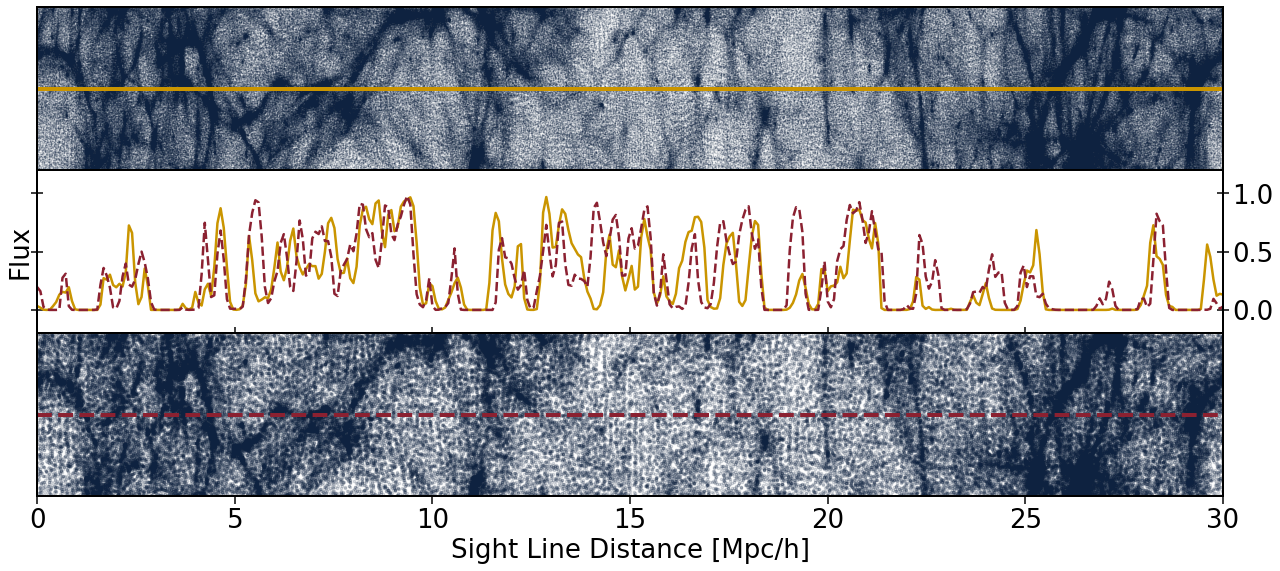

In [5]:
ms, alpha = 0.5, 0.15
fig, ax = plt.subplots(figsize=(2*10.625, 3*3), nrows=3, ncols=1, sharex=True)

# top panel -- high resolution gas density (norm y for easier limits, sightline)
ax[0].plot(part_hi[0]/1000, (part_hi[1]-part_hi[1].min())/(part_hi[1].max()-part_hi[1].min()), 'o', color=c_midnight, ms=ms, alpha=alpha)
ax[0].plot([0, 30], [0.5, 0.5], '-', c=c_sunshine, lw=4)
ax[0].set_yticks([])

# middle panel -- example spectra
ax[1].plot(np.linspace(part_hi[0].min(), part_hi[0].max(), hi_tau.size)/1000, np.exp(-np.roll(hi_tau, 0)), '-', c=c_sunshine, lw=2.5)
ax[1].plot(np.linspace(part_lo[0].min(), part_lo[0].max(), lo_tau.size)/1000, np.exp(-np.roll(lo_tau, 0)), '--', c=c_flatirons, lw=2.5)

# bottom panel -- low resolution gas density (increase marker size by ~8 times to account for fewer particles)
ax[2].plot(part_lo[0]/1000, (part_lo[1]-part_lo[1].min())/(part_lo[1].max()-part_lo[1].min()), 'o', color=c_midnight, ms=5*ms, alpha=alpha)
ax[2].plot([0, 30], [0.5, 0.5], '--', c=c_flatirons, lw=4)
ax[2].set_yticks([])

ax[2].set_xlabel('Sight Line Distance [Mpc/h]', fontsize=26)
ax[1].set_ylabel(r'Flux', fontsize=26)

ax[0].set_xlim([0, 30])
ax[0].set_ylim([0, 1])
ax[1].set_ylim([-0.2, 1.2])
ax[2].set_ylim([0, 1])

ax[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)

fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/spectra_simulation.png", bbox_inches='tight', pad_inches=0)
plt.show()

### Plot of mean error broken down by scale (across all tests, all z) versus number of training simulations

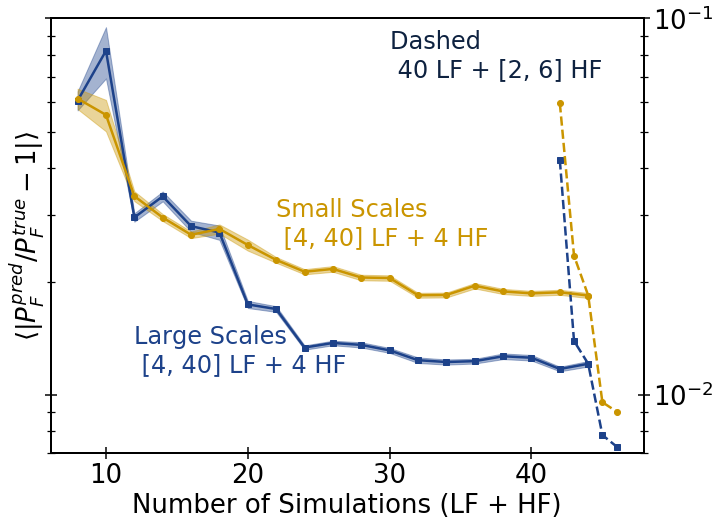

In [6]:
# error with number of training simulations (across all sims, all z, split into small/large scales)
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

absmeanLF, absstdLF, absmeanHF, absstdHF = get_mean_std(base_dir, kf_test, kfmax=0.02)
ax.plot(np.arange(8, 2*absmeanLF.size+8, 2), absmeanLF, 's-', c=c_skyline, lw=2.5)
# plot variance instead of std
ax.fill_between(np.arange(8, 2*absmeanLF.size+8, 2), (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=c_skyline, alpha=0.4)
ax.plot(40+np.arange(2, 7), absmeanHF[3], 's--', c=c_skyline, lw=2.5)

absmeanLF, absstdLF, absmeanHF, absstdHF = get_mean_std(base_dir, kf_test, kfmin=0.02)
ax.plot(np.arange(8, 2*absmeanLF.size+8, 2), absmeanLF, 'o-', c=c_sunshine, lw=2.5)
ax.fill_between(np.arange(8, 2*absmeanLF.size+8, 2), (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=c_sunshine, alpha=0.4)
ax.plot(40+np.arange(2, 7), absmeanHF[3], 'o--', c=c_sunshine, lw=2.5)

ax.text(12, 1.15e-2, 'Large Scales \n [4, 40] LF + 4 HF', c=c_skyline, fontsize=24)
ax.text(22, 2.5e-2, 'Small Scales \n [4, 40] LF + 4 HF', fontsize=24, c=c_sunshine)
ax.text(30, 7e-2, 'Dashed \n 40 LF + [2, 6] HF', fontsize=24, c=c_midnight)

ax.set_xlabel('Number of Simulations (LF + HF)', fontsize=26)
ax.set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([7e-3, 1e-1])
# ax.set_xlim([6, 45])
ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)
ax.patch.set_facecolor('none')

fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/nsim_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Break down the error by k bins

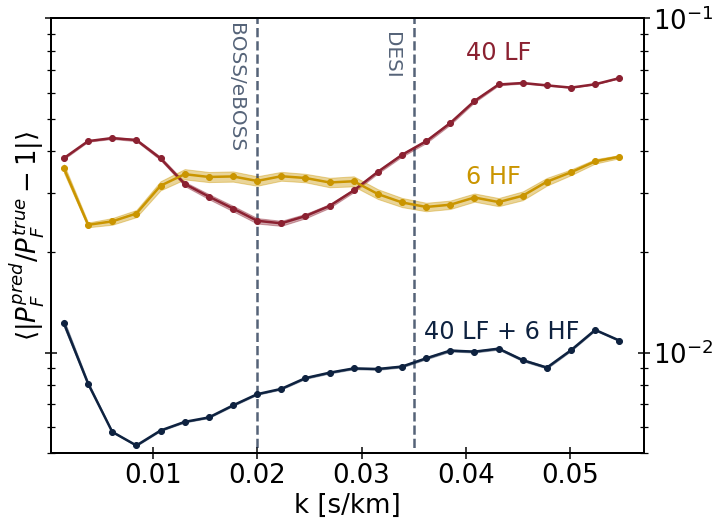

In [7]:
# kf versus error (across all sims, all z) for 40-6 and LF, HF only emulators
# use 25 evenly spaced bins across all tests and z for simplicity
# (24 bin centered values to plot)
nsteps = 25
step = (kf_test.max()-kf_test.min())/nsteps
bins = np.linspace(kf_test.min(), kf_test.max(), nsteps)

# MF emulator (40-6)
file = base_dir+'cc_linear-'+str(40)+'-'+str(6)+'_err.txt'
ccc = np.loadtxt(file).reshape(10, 18, 25)
cmean, cstd = np.zeros(bins.size-1), np.zeros(bins.size-1)
for i in range(1, bins.size):
    cmean[i-1] = np.mean(np.abs(ccc[(kf_test >= bins[i-1]-step/2)*(kf_test < bins[i]+step/2)]-1))
    cstd[i-1] = np.std(np.abs(ccc[(kf_test >= bins[i-1]-step/2)*(kf_test < bins[i]+step/2)]-1))
# LF-only emulator (40)
file = base_dir+'cc_linear-'+str(40)+'lf_err.txt'
ccc = np.loadtxt(file).reshape(10, 18, 25)
lmean, lstd = np.zeros(bins.size-1), np.zeros(bins.size-1)
for i in range(1, bins.size):
    lmean[i-1] = np.mean(np.abs(ccc[(kf_test >= bins[i-1]-step/2)*(kf_test < bins[i]+step/2)]-1))
    lstd[i-1] = np.std(np.abs(ccc[(kf_test >= bins[i-1]-step/2)*(kf_test < bins[i]+step/2)]-1))
# HF-only emulator (6)
file = base_dir+'cc_linear-'+str(6)+'hf_err.txt'
ccc = np.loadtxt(file).reshape(10, 18, 25)
hmean, hstd = np.zeros(bins.size-1), np.zeros(bins.size-1)
for i in range(1, bins.size):
    hmean[i-1] = np.mean(np.abs(ccc[(kf_test >= bins[i-1]-step/2)*(kf_test < bins[i]+step/2)]-1))
    hstd[i-1] = np.std(np.abs(ccc[(kf_test >= bins[i-1]-step/2)*(kf_test < bins[i]+step/2)]-1))

    
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# keep BOSS/DESI lines on lowest layer
ax.plot([0.02, 0.02], [0,100], '--', c=c_midnight, lw=2.5, alpha=0.7)
ax.plot([0.035, 0.035], [0,100], '--', c=c_midnight, lw=2.5, alpha=0.7)
ax.text(0.017, 0.041, 'BOSS/eBOSS', c=c_midnight, fontsize=20, alpha=0.7, rotation=-90)
ax.text(0.032, 0.068, 'DESI', c=c_midnight, fontsize=20, alpha=0.7, rotation=-90)

ax.plot(bins[:-1], cmean, 'o-', c=c_midnight, lw=2.5)
ax.fill_between(bins[:-1], (cmean-cstd**2), (cmean+cstd**2), color=c_midnight, alpha=0.4)
ax.text(0.036, 1.1e-2, '40 LF + 6 HF', color=c_midnight, fontsize=24)
ax.plot(bins[:-1], lmean, 'o-', c=c_flatirons, lw=2.5)
ax.fill_between(bins[:-1], (lmean-lstd**2), (lmean+lstd**2), color=c_flatirons, alpha=0.4)
ax.text(0.04, 7.5e-2, '40 LF', c=c_flatirons, fontsize=24)
ax.plot(bins[:-1], hmean, 'o-', color=c_sunshine, lw=2.5)
ax.fill_between(bins[:-1], (hmean-hstd**2), (hmean+hstd**2), color=c_sunshine, alpha=0.4)
ax.text(0.04, 3.2e-2, '6 HF', color=c_sunshine, fontsize=24)

ax.set_xlabel(r'k [s/km]', fontsize=26)
ax.set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([5e-3, 1e-1])
ax.set_xlim([kf_test.min()*0.1, kf_test.max()])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8)

ax.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/kf_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Break down the errors by redshift and scales

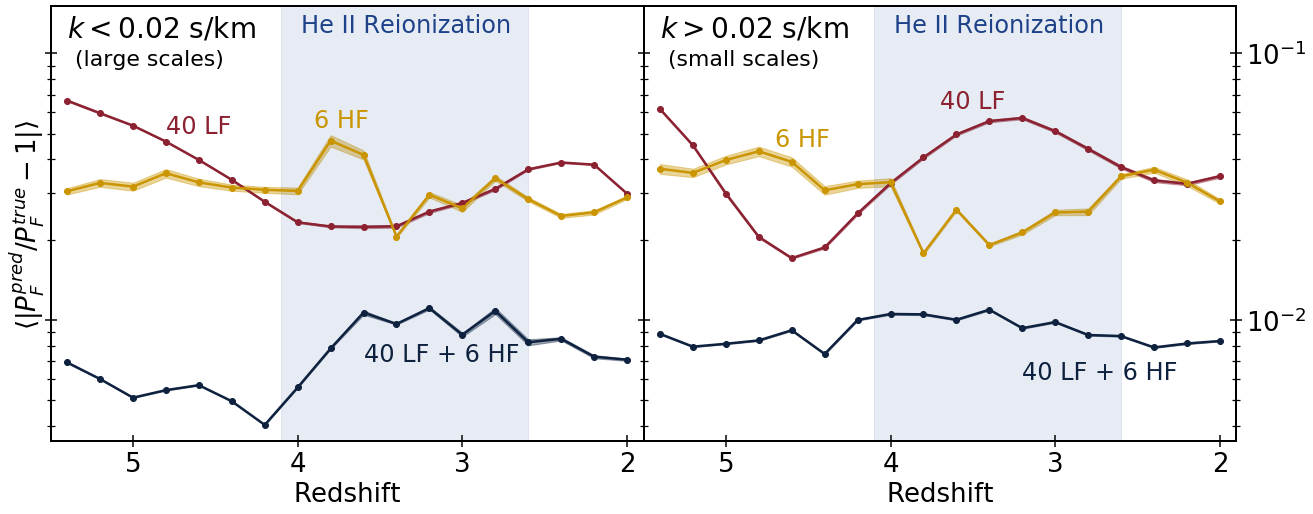

In [8]:
# z versus small and large scale error (all sims) for 40-4, LF and HF only
fig, ax = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)
plt.setp(ax, ylim=[3.5e-3, 1.5e-1], xlim=[5.5, 1.9], yscale='log')

lfmean, lfstd = get_mean_std_one(base_dir, kf_test, 40, None, z_or_k='z', kfmax=0.02)
hfmean, hfstd = get_mean_std_one(base_dir, kf_test, None, 6, z_or_k='z', kfmax=0.02)
absmeanLF, absstdLF = get_mean_std_one(base_dir, kf_test, 40, 6, z_or_k='z', kfmax=0.02)

ax[0].plot(zz, lfmean, 'o-', c=c_flatirons, lw=2.5)
ax[0].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4)
ax[0].plot(zz, hfmean, 'o-', color=c_sunshine, lw=2.5)
ax[0].fill_between(zz, (hfmean-hfstd**2), (hfmean+hfstd**2), color=c_sunshine, alpha=0.4)
ax[0].plot(zz, absmeanLF, 'o-', c=c_midnight, lw=2.5)
ax[0].fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=c_midnight, alpha=0.4)

lfmean, lfstd = get_mean_std_one(base_dir, kf_test, 40, None, z_or_k='z', kfmin=0.02)
hfmean, hfstd = get_mean_std_one(base_dir, kf_test, None, 6, z_or_k='z', kfmin=0.02)
absmeanLF, absstdLF = get_mean_std_one(base_dir, kf_test, 40, 6, z_or_k='z', kfmin=0.02)

ax[1].plot(zz, lfmean, 'o-', c=c_flatirons, lw=2.5)
ax[1].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4)
ax[1].plot(zz, hfmean, 'o-', color=c_sunshine, lw=2.5)
ax[1].fill_between(zz, (hfmean-hfstd**2), (hfmean+hfstd**2), color=c_sunshine, alpha=0.4)
ax[1].plot(zz, absmeanLF, 'o-', c=c_midnight, lw=2.5)
ax[1].fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=c_midnight, alpha=0.4)

ax[0].text(4.8, 5e-2, '40 LF', c=c_flatirons, fontsize=24)
ax[0].text(3.9, 5.3e-2, '6 HF', color=c_sunshine, fontsize=24)
ax[0].text(3.6, 0.7e-2, '40 LF + 6 HF', c=c_midnight, fontsize=24)
ax[0].fill_between([4.1, 2.6], [3e-3, 3e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
ax[0].text(3.98, 1.2e-1, r'He II Reionization', c=c_skyline, fontsize=24)
ax[0].text(5.4, 1.15e-1, '$k < 0.02$ s/km', color='k', fontsize=28)
ax[0].text(5.35, 0.9e-1, '(large scales)', color='k', fontsize=22)
ax[1].text(3.7, 6.2e-2, '40 LF', c=c_flatirons, fontsize=24)
ax[1].text(4.7, 4.5e-2, '6 HF', color=c_sunshine, fontsize=24)
ax[1].text(3.2, 0.6e-2, '40 LF + 6 HF', c=c_midnight, fontsize=24)
ax[1].fill_between([4.1, 2.6], [3e-3, 3e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
ax[1].text(3.98, 1.2e-1, r'He II Reionization', c=c_skyline, fontsize=24)
ax[1].text(5.4, 1.15e-1, '$k > 0.02$ s/km', color='k', fontsize=28)
ax[1].text(5.35, 0.9e-1, '(small scales)', color='k', fontsize=22)

ax[0].set_xlabel(r'Redshift', fontsize=26)
ax[1].set_xlabel(r'Redshift', fontsize=26)
ax[0].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)

ax[0].tick_params(which='both', direction='inout', labelleft=False, length=12)
ax[0].tick_params(which='minor', length=8)
ax[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax[1].tick_params(which='minor', length=8)

ax[0].patch.set_facecolor('none')
ax[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/z_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Compare errors to non-linear GP

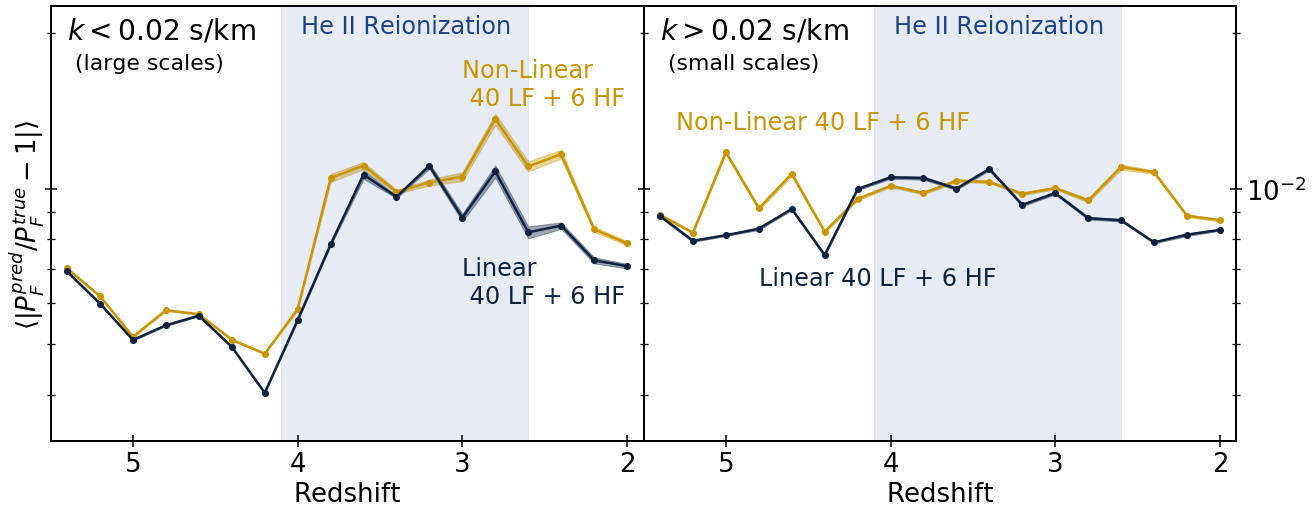

In [9]:
# z versus small and large scale error (all sims) for ar1 and nargp
fig, ax = plt.subplots(figsize=(2*10.625, 8), nrows=1, ncols=2, sharey=True)
plt.setp(ax, ylim=[3.25e-3, 2.25e-2], xlim=[5.5, 1.9], yscale='log')

nargpmean, nargpstd = get_mean_std_one(base_dir, kf_test, 40, 6, kfmax=0.02, z_or_k='z', nargp=True)
absmeanLF, absstdLF = get_mean_std_one(base_dir, kf_test, 40, 6, kfmax=0.02, z_or_k='z')
ax[0].plot(zz, nargpmean, 'o-', color=c_sunshine, lw=2.5)
ax[0].fill_between(zz, (nargpmean-nargpstd**2), (nargpmean+nargpstd**2), color=c_sunshine, alpha=0.4)
ax[0].plot(zz, absmeanLF, 'o-', c=c_midnight, lw=2.5)
ax[0].fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=c_midnight, alpha=0.4)

nargpmean, nargpstd = get_mean_std_one(base_dir, kf_test, 40, 6, kfmin=0.02, z_or_k='z', nargp=True)
absmeanLF, absstdLF = get_mean_std_one(base_dir, kf_test, 40, 6, kfmin=0.02, z_or_k='z')
ax[1].plot(zz, nargpmean, 'o-', color=c_sunshine, lw=2.5)
ax[1].fill_between(zz, (nargpmean-nargpstd**2), (nargpmean+nargpstd**2), color=c_sunshine, alpha=0.4)
ax[1].plot(zz, absmeanLF, 'o-', c=c_midnight, lw=2.5)
ax[1].fill_between(zz, (absmeanLF-absstdLF**2), (absmeanLF+absstdLF**2), color=c_midnight, alpha=0.4)

ax[0].text(3, 1.45e-2, 'Non-Linear \n 40 LF + 6 HF', color=c_sunshine, fontsize=24)
ax[0].text(3, 0.6e-2, 'Linear \n 40 LF + 6 HF', c=c_midnight, fontsize=24)
ax[0].fill_between([4.1, 2.6], [1e-3, 1e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
ax[1].text(5.3, 1.3e-2, 'Non-Linear 40 LF + 6 HF', color=c_sunshine, fontsize=24)
ax[1].text(4.8, 0.65e-2, 'Linear 40 LF + 6 HF', c=c_midnight, fontsize=24)
ax[1].fill_between([4.1, 2.6], [1e-3, 1e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
ax[0].text(3.98, 2e-2, r'He II Reionization', c=c_skyline, fontsize=24)
ax[0].text(5.4, 1.95e-2, '$k < 0.02$ s/km', color='k', fontsize=28)
ax[0].text(5.35, 1.7e-2, '(large scales)', color='k', fontsize=22)
ax[1].text(3.98, 2e-2, r'He II Reionization', c=c_skyline, fontsize=24)
ax[1].text(5.4, 1.95e-2, '$k > 0.02$ s/km', color='k', fontsize=28)
ax[1].text(5.35, 1.7e-2, '(small scales)', color='k', fontsize=22)

ax[0].set_xlabel(r'Redshift', fontsize=26)
ax[1].set_xlabel(r'Redshift', fontsize=26)
ax[0].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
ax[1].set_yticks([0.01])
ax[1].set_yticklabels([], minor=True)

ax[0].tick_params(which='both', direction='inout', labelleft=False, length=12)
ax[0].tick_params(which='minor', length=8)
ax[1].tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax[1].tick_params(which='minor', length=8)

ax[0].patch.set_facecolor('none')
ax[1].patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/non-linear_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Total computation time and error

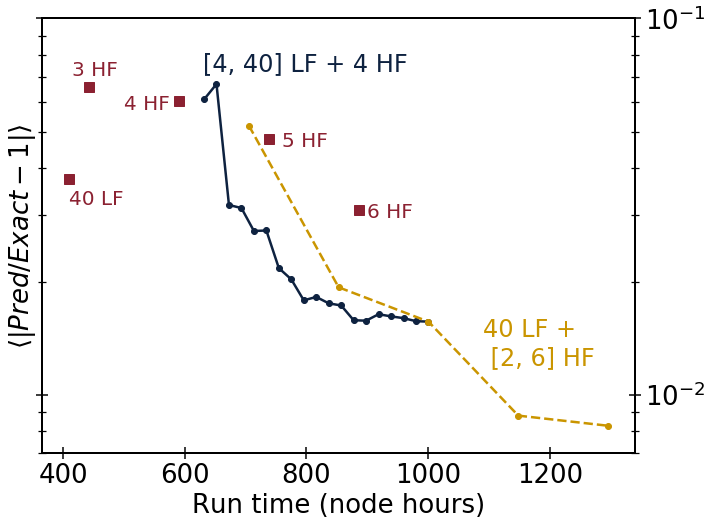

In [10]:
# optimization times converted to hours -- too subdominant to matter
times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
times_3hf = np.array([118, 174, 172, 192])/60
times_2hf = np.array([92, 178, 193, 202])/60

# used 16 nodes for these gadget runs
time_per_lfsim = 16*np.mean(np.array([3241,1762,3001,2156,2695,1795,1787,1875,2146,2377,1853,2158,1494,2921,2820,1955,2940,2527])/3600)
# used 32 nodes for these gadget runs
time_per_hfsim = 32*np.mean(np.array([15276,18993,15860,14625,18300])/3600)

# get LF-only (40) and HF-only (3-6) and AR1 (40-6)
lf_40 = np.loadtxt(base_dir+'cc_linear-40lf_err.txt')
hf_3 = np.loadtxt(base_dir+'cc_linear-3hf_err.txt')
hf_4 = np.loadtxt(base_dir+'cc_linear-4hf_err.txt')
hf_5 = np.loadtxt(base_dir+'cc_linear-5hf_err.txt')
hf_6 = np.loadtxt(base_dir+'cc_linear-6hf_err.txt')
absmeanLF, absstdLF, absmeanHF, absstdHF = get_mean_std(base_dir, kf_test)

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

ax.plot(40*time_per_lfsim, np.mean(np.abs(lf_40 - 1)), 's', c=c_flatirons, ms=10)
ax.plot(3*time_per_hfsim, np.mean(np.abs(hf_3 - 1)), 's', c=c_flatirons, ms=10)
ax.plot(4*time_per_hfsim, np.mean(np.abs(hf_4 - 1)), 's', c=c_flatirons, ms=10)
ax.plot(5*time_per_hfsim, np.mean(np.abs(hf_5 - 1)), 's', c=c_flatirons, ms=10)
ax.plot(6*time_per_hfsim, np.mean(np.abs(hf_6 - 1)), 's', c=c_flatirons, ms=10)
ax.plot(np.arange(4, 2*absmeanLF.size+4, 2)*time_per_lfsim + 4*time_per_hfsim, absmeanLF, 'o-', c=c_midnight, lw=2.5)
ax.plot((3+1)*10*time_per_lfsim + np.arange(2, 7)*time_per_hfsim, absmeanHF[3], 'o--', lw=2.5, color=c_sunshine)

ax.text(410, 0.85*np.mean(np.abs(lf_40 - 1)), '40 LF', fontsize=20, color=c_flatirons)
ax.text(415, 1.07*np.mean(np.abs(hf_3 - 1)), '3 HF', fontsize=20, color=c_flatirons)
ax.text(500, 0.95*np.mean(np.abs(hf_4 - 1)), '4 HF', fontsize=20, color=c_flatirons)
ax.text(760, 0.95*np.mean(np.abs(hf_5 - 1)), '5 HF', fontsize=20, color=c_flatirons)
ax.text(900, 0.95*np.mean(np.abs(hf_6 - 1)), '6 HF', fontsize=20, color=c_flatirons)
ax.text(630, 7.25e-2, '[4, 40] LF + 4 HF', c=c_midnight, fontsize=24)
ax.text(1090, 1.2e-2, '40 LF + \n [2, 6] HF', fontsize=24, color=c_sunshine)

ax.set_xlabel('Run time (node hours)', fontsize=26)
ax.set_ylabel(r'$\langle\| Pred/Exact - 1 \|\rangle$', fontsize=26)
ax.set_yscale('log')
ax.set_ylim([7e-3, 1e-1])
# ax.set_xlim([400, 1020])

ax.tick_params(which='both', direction='inout', right=True, labelright=True, labelleft=False, length=12)
ax.tick_params(which='minor', length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor('none')
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("../figures/runtime_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Plot showing the parameter samples

In [11]:
def plot_samples(lores_json, hires_json, savefile=None, bo_samps=None):
    # get samples
    hires = np.array(json.load(open(hires_json, 'r'))['sample_params'])
    lores = np.array(json.load(open(lores_json, 'r'))['sample_params'])
    nsim, npar = np.shape(lores)
    
    # Bayesian optimization samples, if present
    if bo_samps is not None:
        bo = np.array(json.load(open(bo_samps, 'r'))['sample_params'])
        uu, nn = np.unique(np.concatenate([lores, bo]), axis=0, return_counts=True)
        bo = uu[np.where(nn==1)]
    
    # get parameter limits
    plimits = np.array(json.load(open(lores_json, 'r'))['param_limits'])

    # parameter names - better formatting than from the json file
    names = [r'$\bf{n_s}$', r'$\bf{A_p}$', r'$\bf{z^{HeII}_i}$', r'$\bf{z^{HeII}_f}$', r'$\bf{\alpha_q}$', r'$\bf{h}$', r'$\bf{\Omega_M h^2}$', 
             r'$\bf{z^{HI}}$', r'$\bf{BHF}$']
    
    # make the plot
    yy = np.ones(nsim)
    fig, ax = plt.subplots(figsize=(10.625, 11), nrows=npar, ncols=1)
    for i in range(npar):
        ax[i].set_yticks([i])
        ax[i].set_yticklabels([names[i]], fontsize=26)
        ax[i].plot(lores[:, i], i*yy, 'x', color=c_midnight, ms=15, mew=2.5, alpha=0.66)
        if bo_samps is not None:
            ax[i].plot(bo[:, i], i*np.ones(np.shape(bo)[0]), 's', color=c_sunshine, ms=15, mew=3, mfc='none')
        ax[i].plot(hires[:, i], i*np.ones(np.shape(hires)[0]), 'o', color=c_flatirons, ms=15, mew=3, mfc='none')
        
        ax[i].set_xlim(plimits[i])
        ax[i].set_xticks(plimits[i])
        ax[i].set_xticklabels(plimits[i])

        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].yaxis.set_ticks_position('left')
        ax[i].xaxis.set_ticks_position('bottom')    
        ax[i].patch.set_facecolor('none')

    fig.subplots_adjust(hspace=2, wspace=0)
    if savefile is not None:
        fig.savefig("../figures/"+savefile+".pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

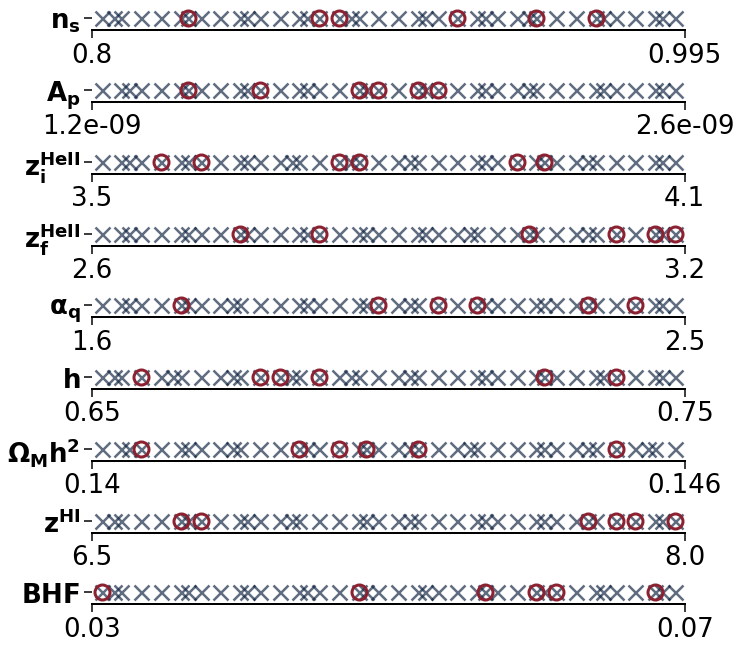

In [12]:
# current emulator setup
plot_samples(emudir+'lores/emulator_params.json-40', emudir+'hires/emulator_params.json-6' )